<a href="https://www.kaggle.com/code/ugyenntsheringg/predicting-loan-defaults-with-deep-learning?scriptVersionId=235720619" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# African Credit Scoring Challenge 
Can you predict the likelihood of a customer defaulting on a loan based on their financial data ?
Financial institutions need to predict loan defaults to mitigate risk and optimise lending decisions. In Africa’s rapidly growing financial markets, with diverse customer demographics and dynamic economic conditions, accurately assessing default risk is more important than ever.

In this challenge, we want you to develop a robust, generalisable machine learning model to predict the likelihood of loan defaults for both existing customers and new applicants. Beyond accurate predictions, we encourage yous to innovate by incorporating unique factors relevant to each financial market.

The objective of this challenge is to develop a machine learning model that accurately predicts the probability of loan default.

The top 10 winners, in addition to submitting their solution, will need to design and submit a credit scoring function, using their model's outputs and probabilities. This step involves binning model outputs into risk categories and proposing a scalable credit risk score.

By accurately predicting loan defaults, your work will enable the client organisation to create a credit scoring solution to evaluate risk more effectively, improving decisionmaking, reducing financial losses associated with high-risk lending, and allowing for expansion into new financial markets.

The challenge provider is a private asset manager that operates in several financial markets across Africa.

### Dataset 
Link: https://zindi.africa/competitions/african-credit-scoring-challenge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Load the train and test datasets
train_data = pd.read_csv('/kaggle/input/african-credit-scoring-challenge-dataset/Train.csv')
test_data = pd.read_csv('/kaggle/input/african-credit-scoring-challenge-dataset/Test (1).csv')

display('Train Dataset Head', train_data.head())
display('Test Dataset Head', test_data.head())

'Train Dataset Head'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


'Test Dataset Head'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


In [3]:
#Checking for missing values
print(f"There are {train_data.isna().sum().sum()} missing values in the train data.")
print(f"There are {test_data.isna().sum().sum()} missing values in the test data.")

There are 0 missing values in the train data.
There are 0 missing values in the test data.


In [4]:
#Checkign for duplicates
print(f"There are {train_data.duplicated().sum()} duplicate rows in the train data.")
print(f"There are {test_data.duplicated().sum()} duplicate rows in the test data.")

There are 0 duplicate rows in the train data.
There are 0 duplicate rows in the test data.



Target Variable Distribution:
target
0    0.981676
1    0.018324
Name: proportion, dtype: float64


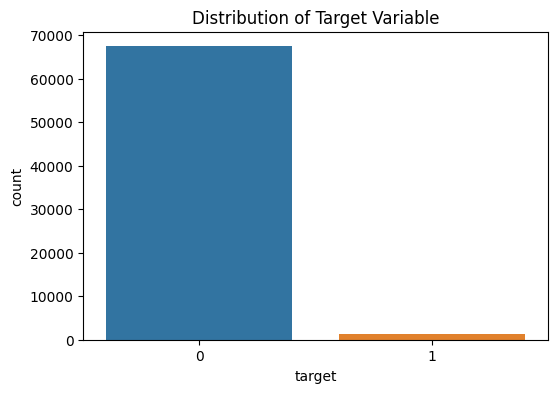

In [5]:
# Check the distribution of the target variable
print("\nTarget Variable Distribution:")
print(train_data['target'].value_counts(normalize=True))

# Visualize the target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

In [6]:
# Identify numerical features
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude target column if it's in the list of numerical features
# Remove 'target' and 'customer_id' from numerical_features, if they exist
numerical_features = [col for col in numerical_features if col not in ['target', 'customer_id', 'lender_id', 'Lender_portion_to_be_repaid']]

# Print numerical features
print("Numerical Features:", numerical_features)

Numerical Features: ['tbl_loan_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded']


Training Dataset


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

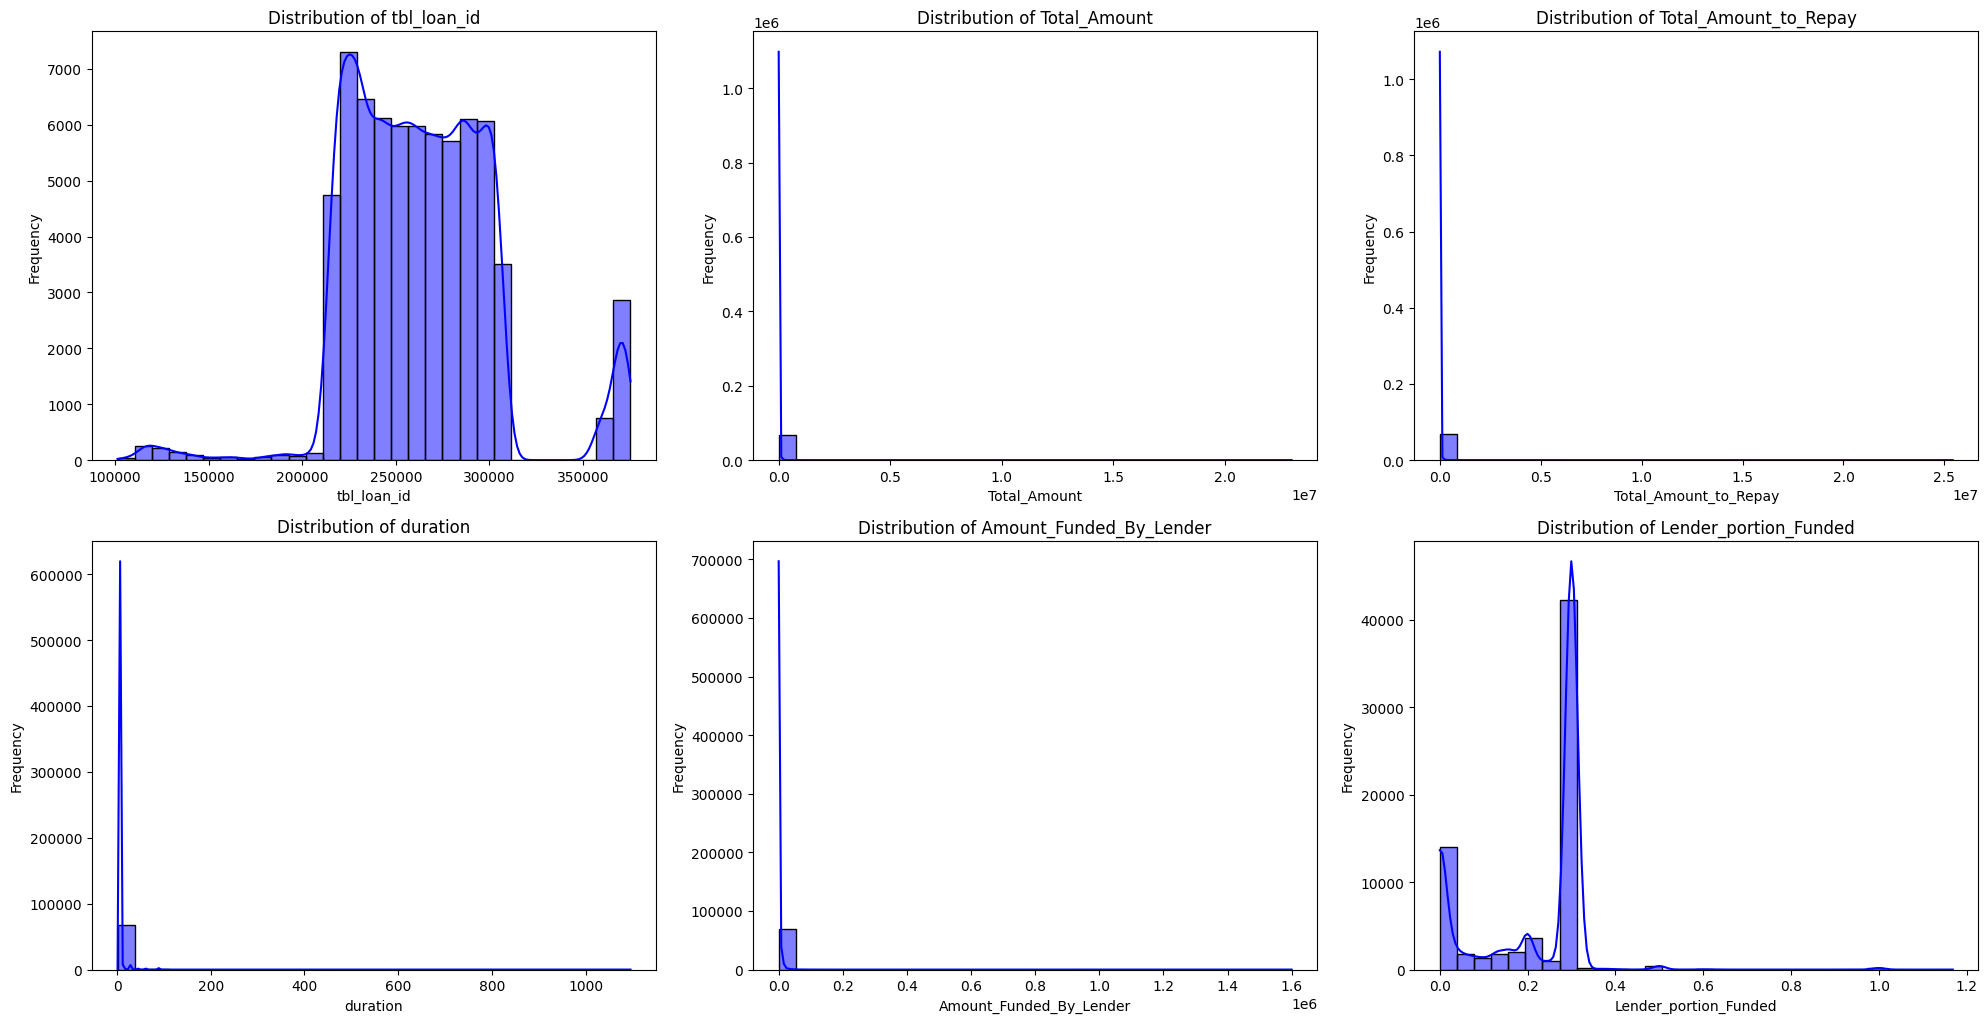

Testing Dataset


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

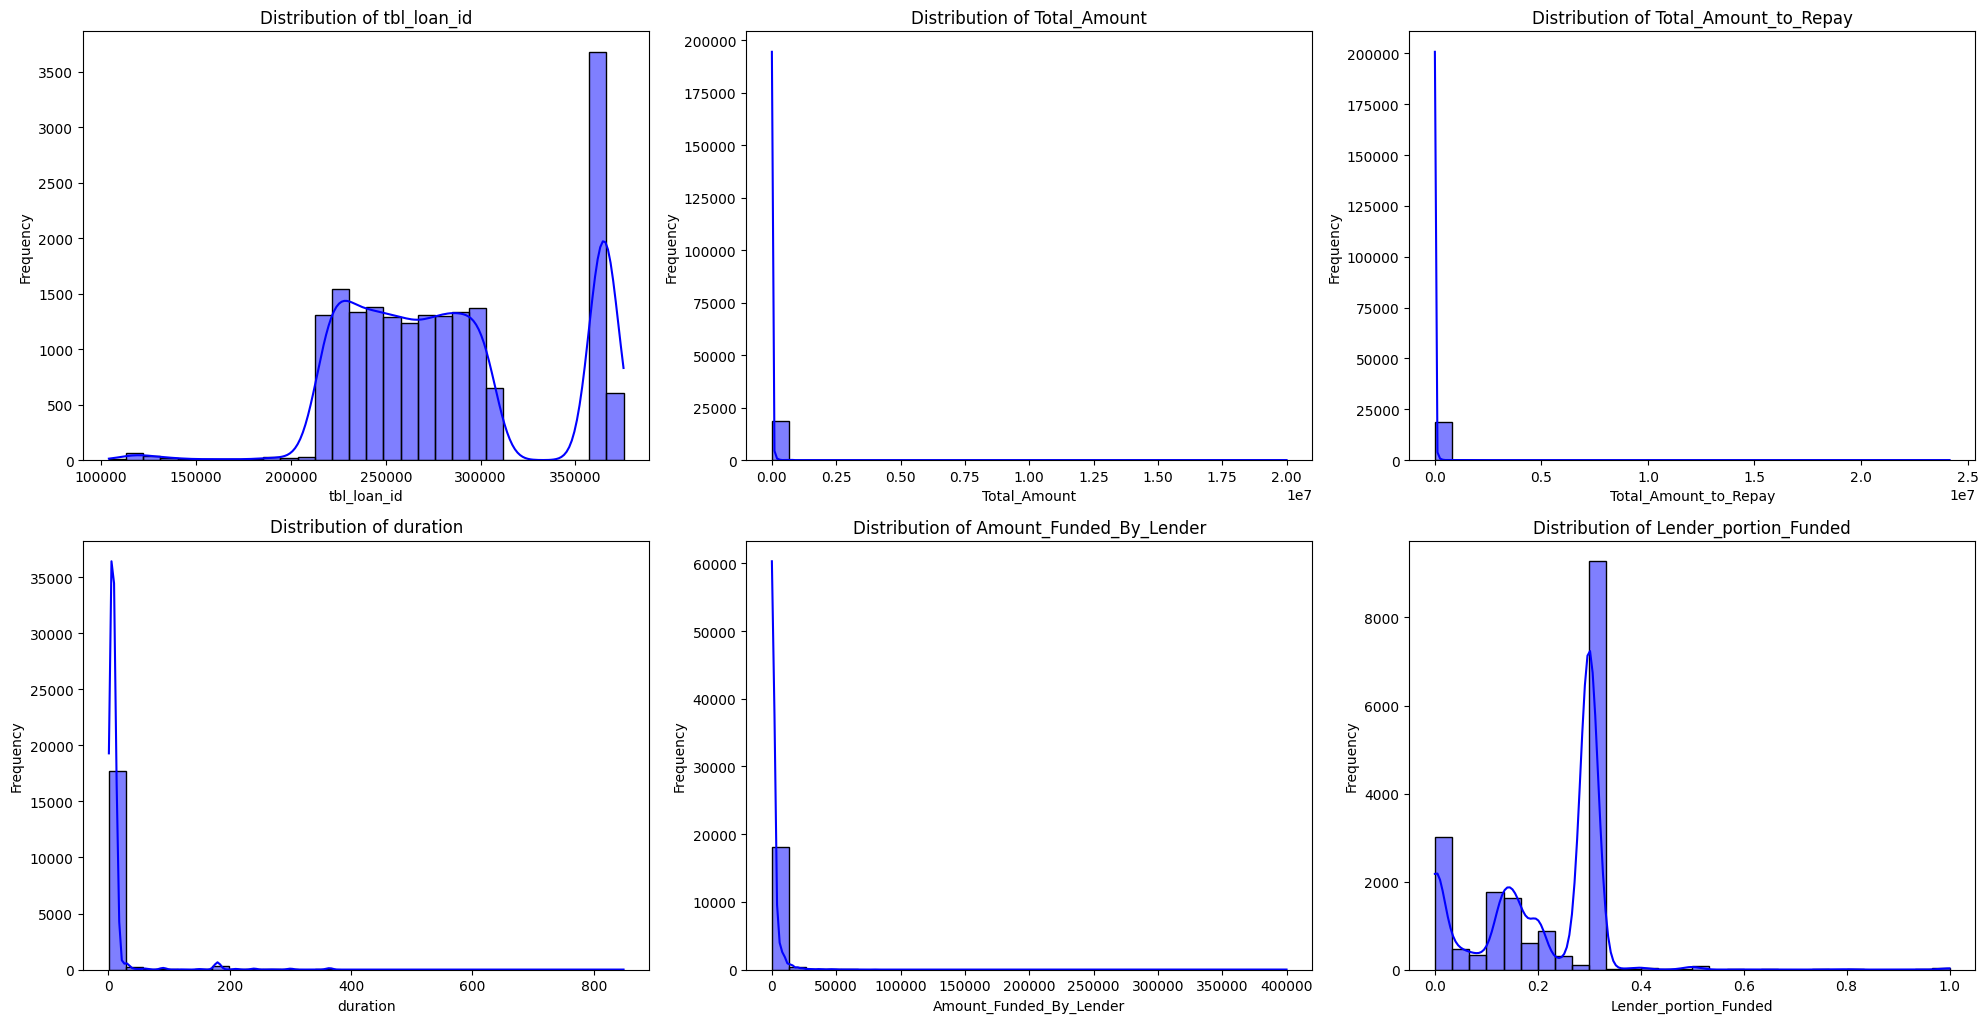

In [7]:
print("Training Dataset")
# Plot histograms for numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Testing Dataset")
# Plot histograms for numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(test_data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
# Apply log transformation to skewed numerical columns
train_data['Total_Amount'] = np.log1p(train_data['Total_Amount'])
train_data['Total_Amount_to_Repay'] = np.log1p(train_data['Total_Amount_to_Repay'])
train_data['Amount_Funded_By_Lender'] = np.log1p(train_data['Amount_Funded_By_Lender'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[['duration']] = scaler.fit_transform(train_data[['duration']])

test_data['Total_Amount'] = np.log1p(test_data['Total_Amount'])
test_data['Total_Amount_to_Repay'] = np.log1p(test_data['Total_Amount_to_Repay'])
test_data['Amount_Funded_By_Lender'] = np.log1p(test_data['Amount_Funded_By_Lender'])

test_data[['duration']] = scaler.fit_transform(test_data[['duration']])

Training Dataset


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

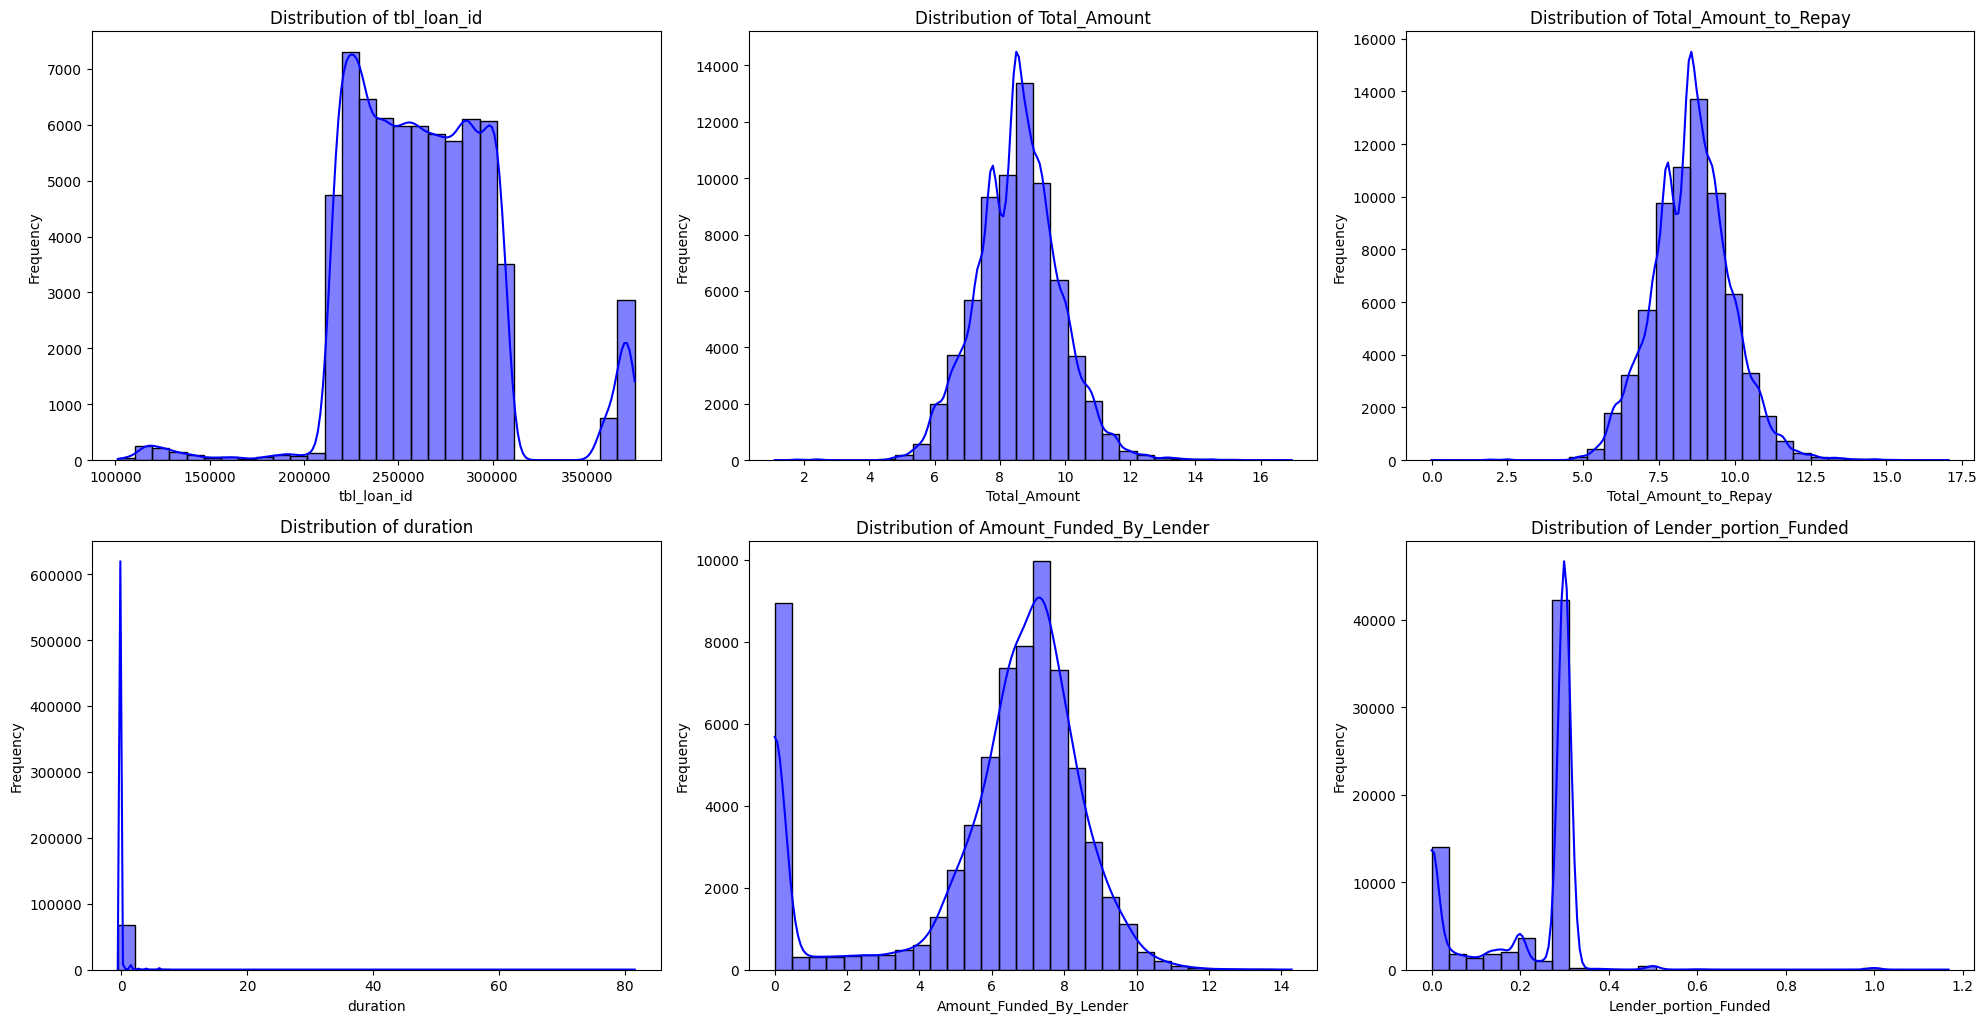

Testing Dataset


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

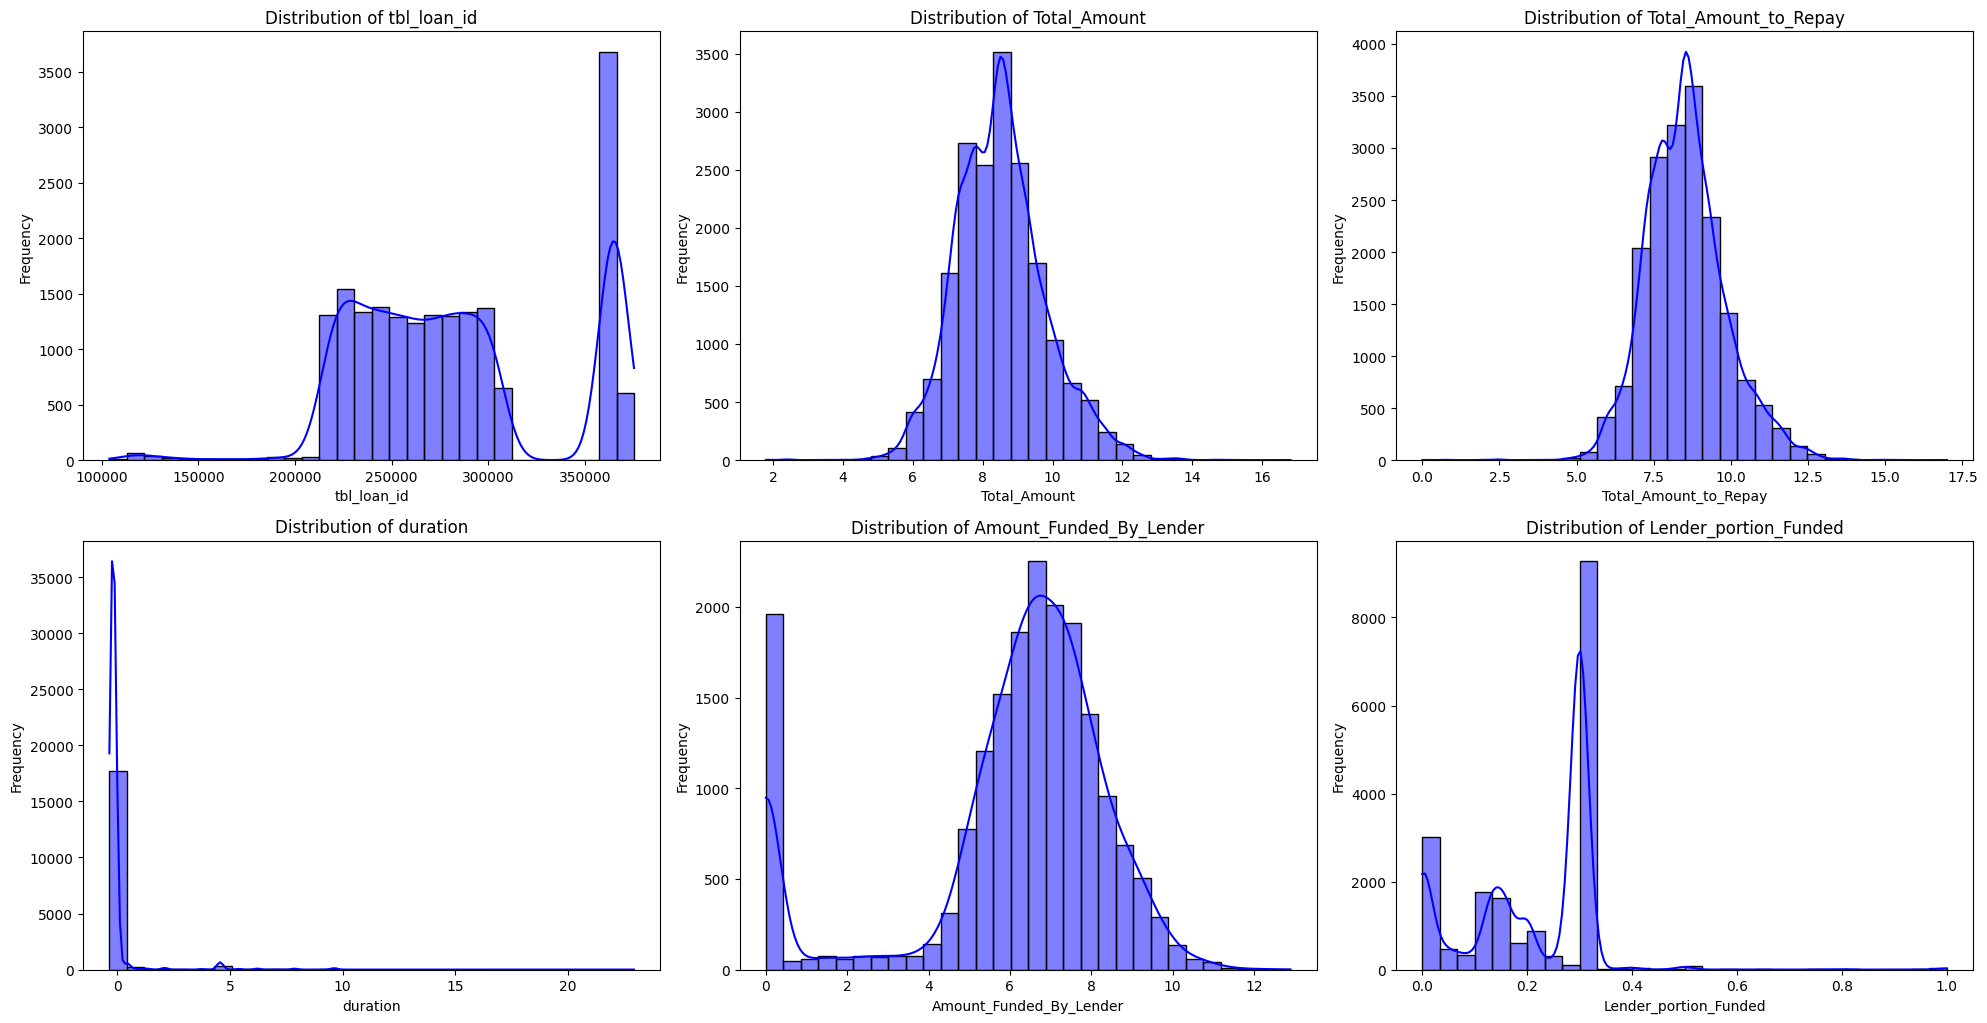

In [9]:
print("Training Dataset")
# Plot histograms for numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Testing Dataset")
# Plot histograms for numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(test_data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Train Data


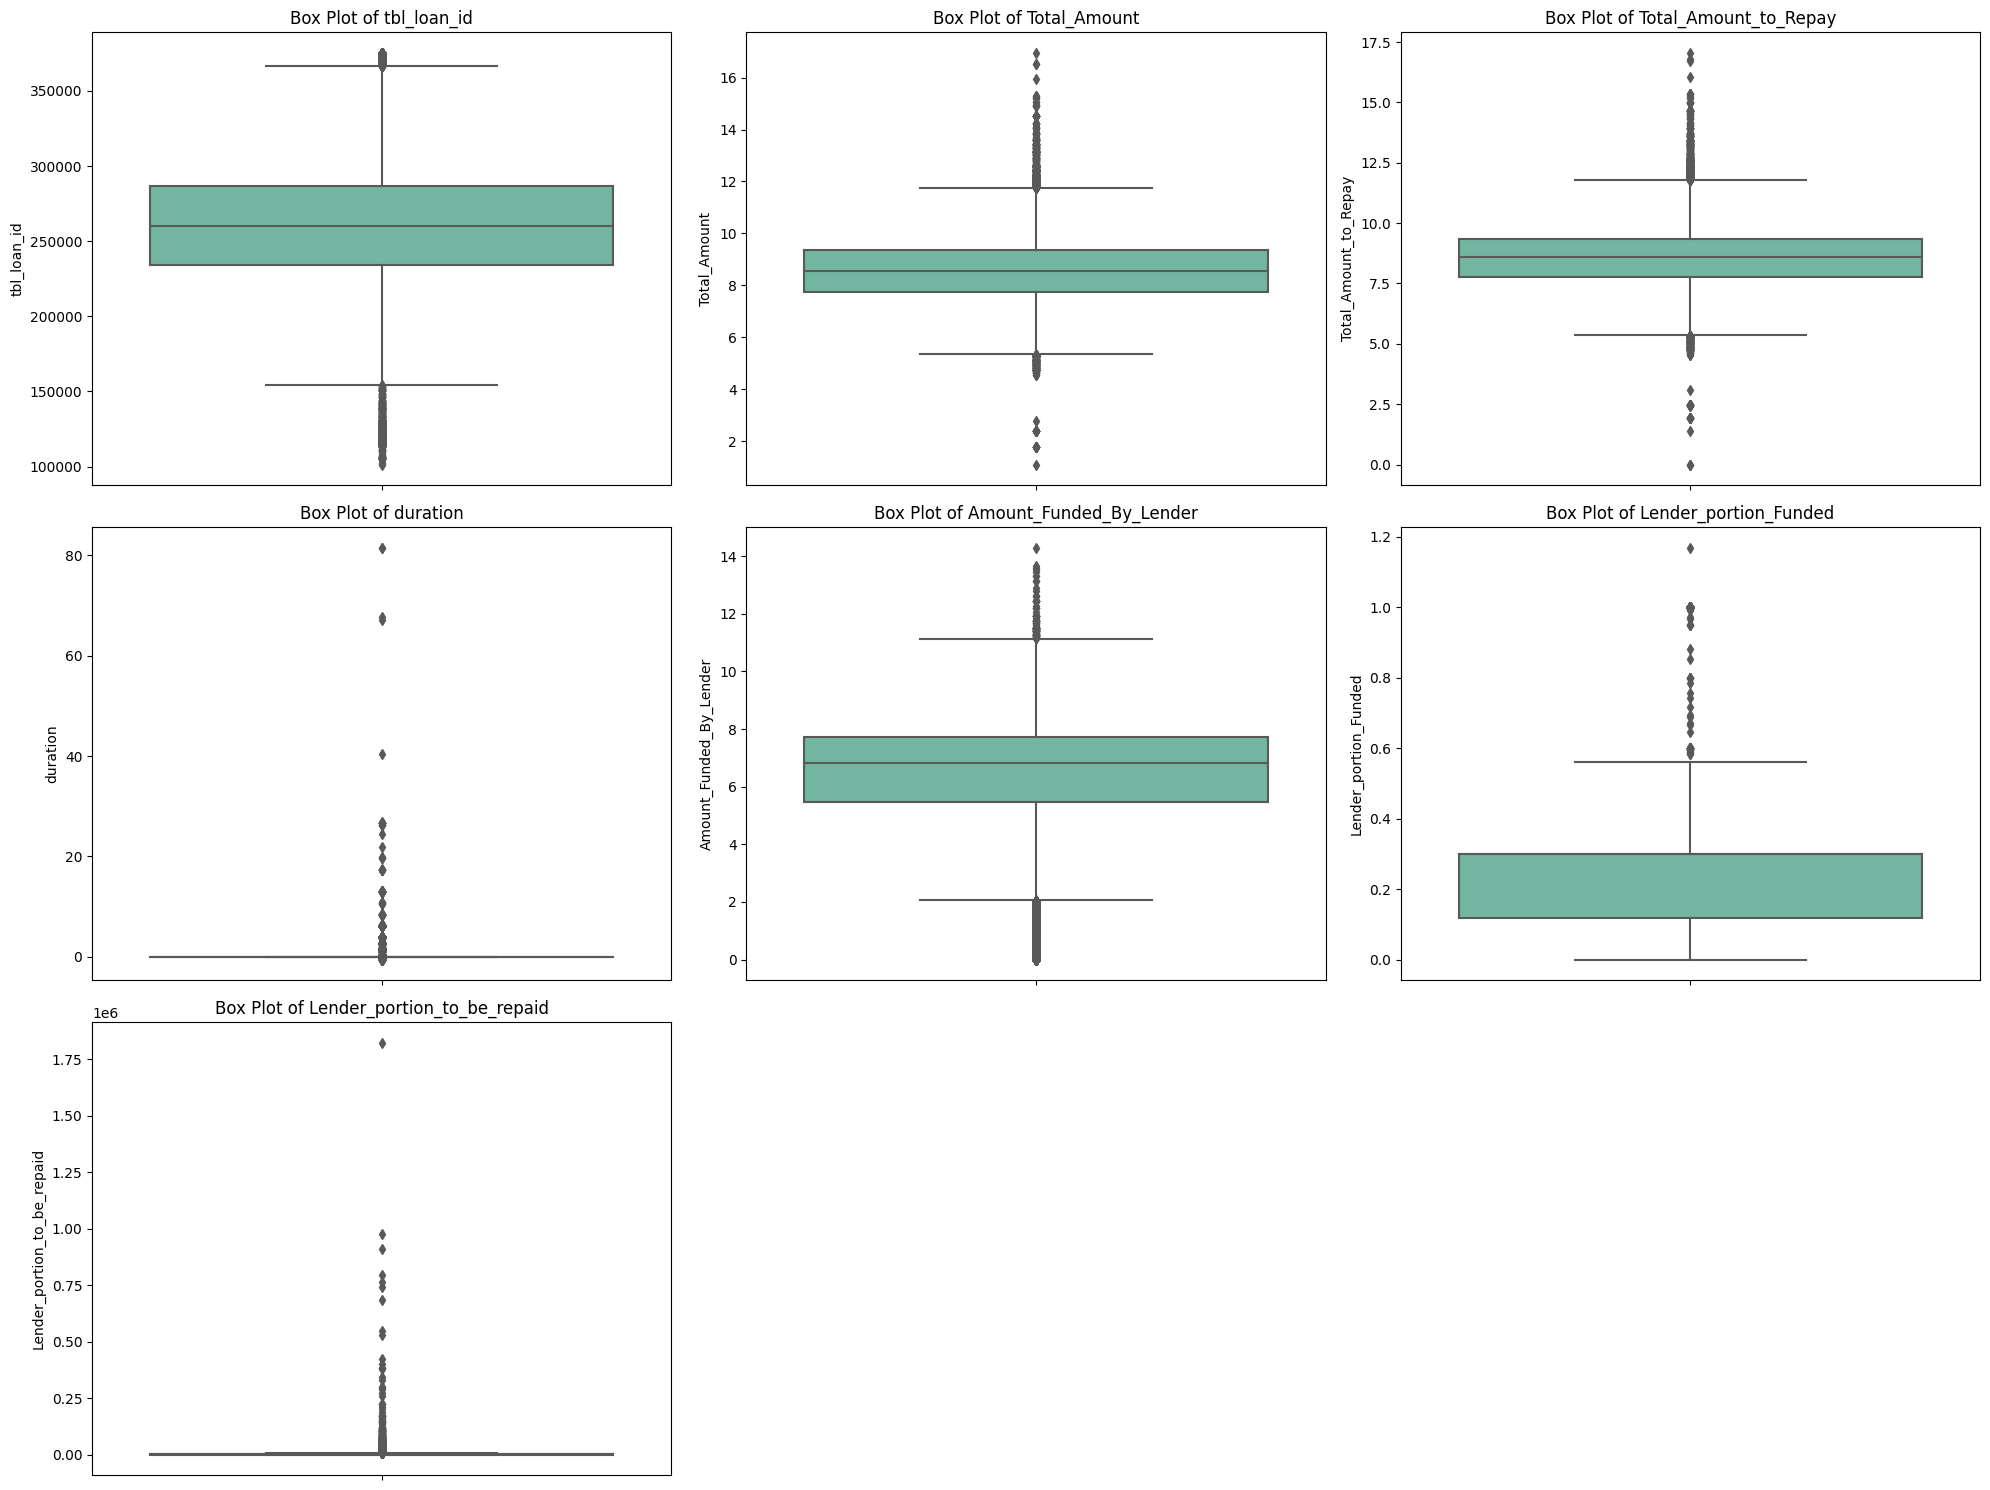

Test Data


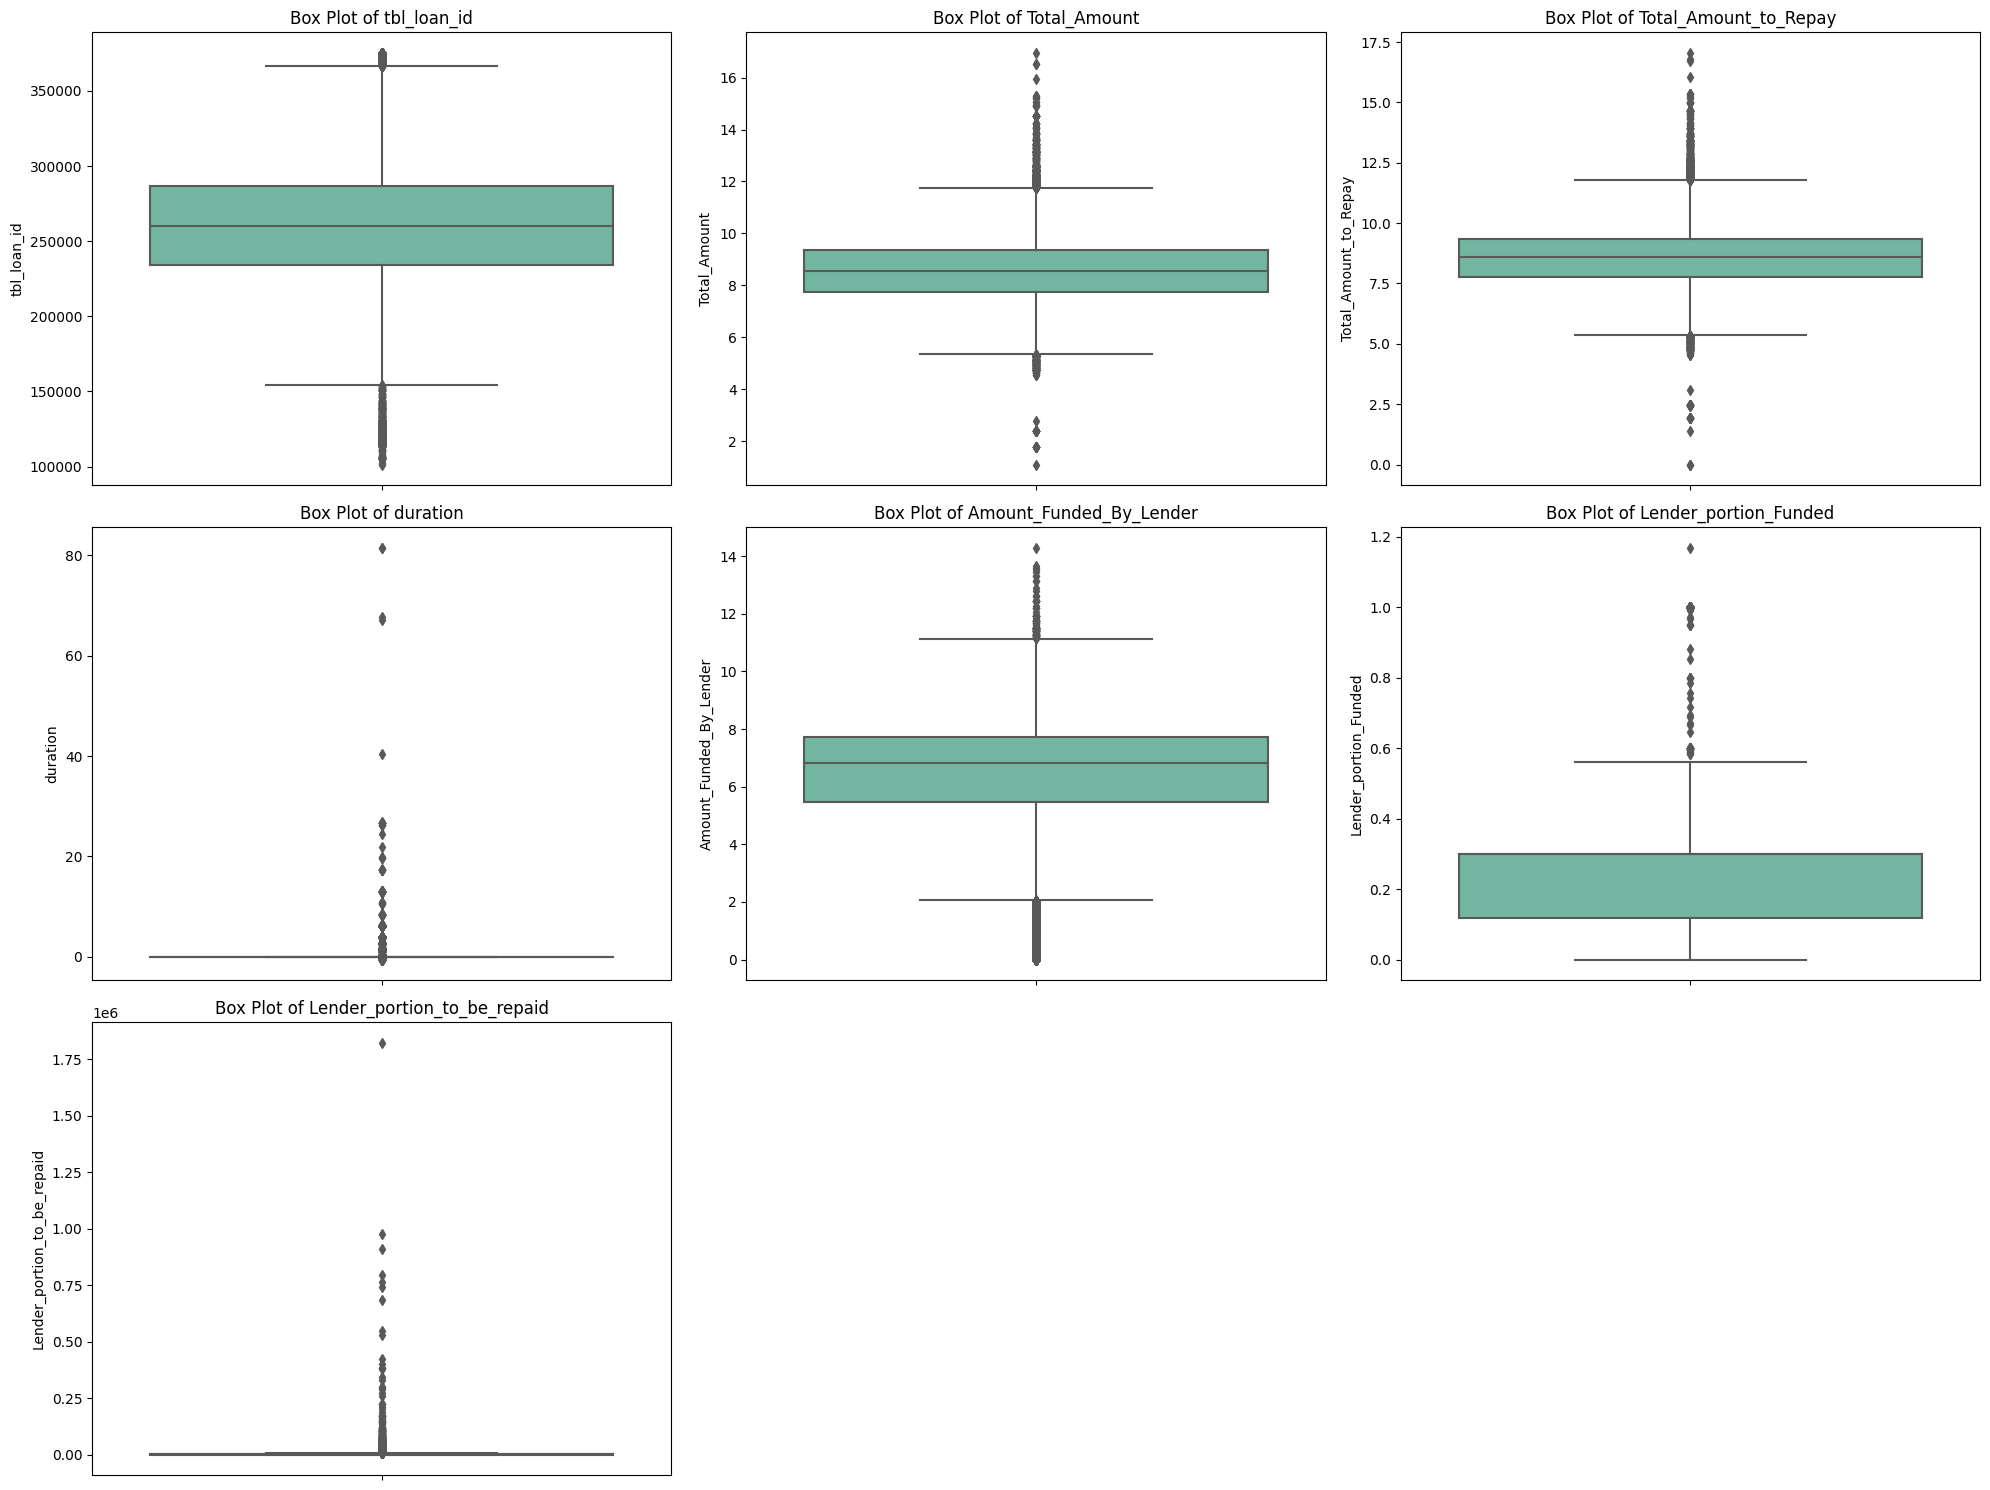

In [10]:
numerical_feature = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_feature = [col for col in numerical_feature if col not in ['target', 'customer_id', 'lender_id']]

print('Train Data')
# Assuming numerical_features is a list of your numerical feature names
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_feature, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=feature, data=train_data, palette='Set2')
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

print('Test Data')
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_feature, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=feature, data=train_data, palette='Set2')
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

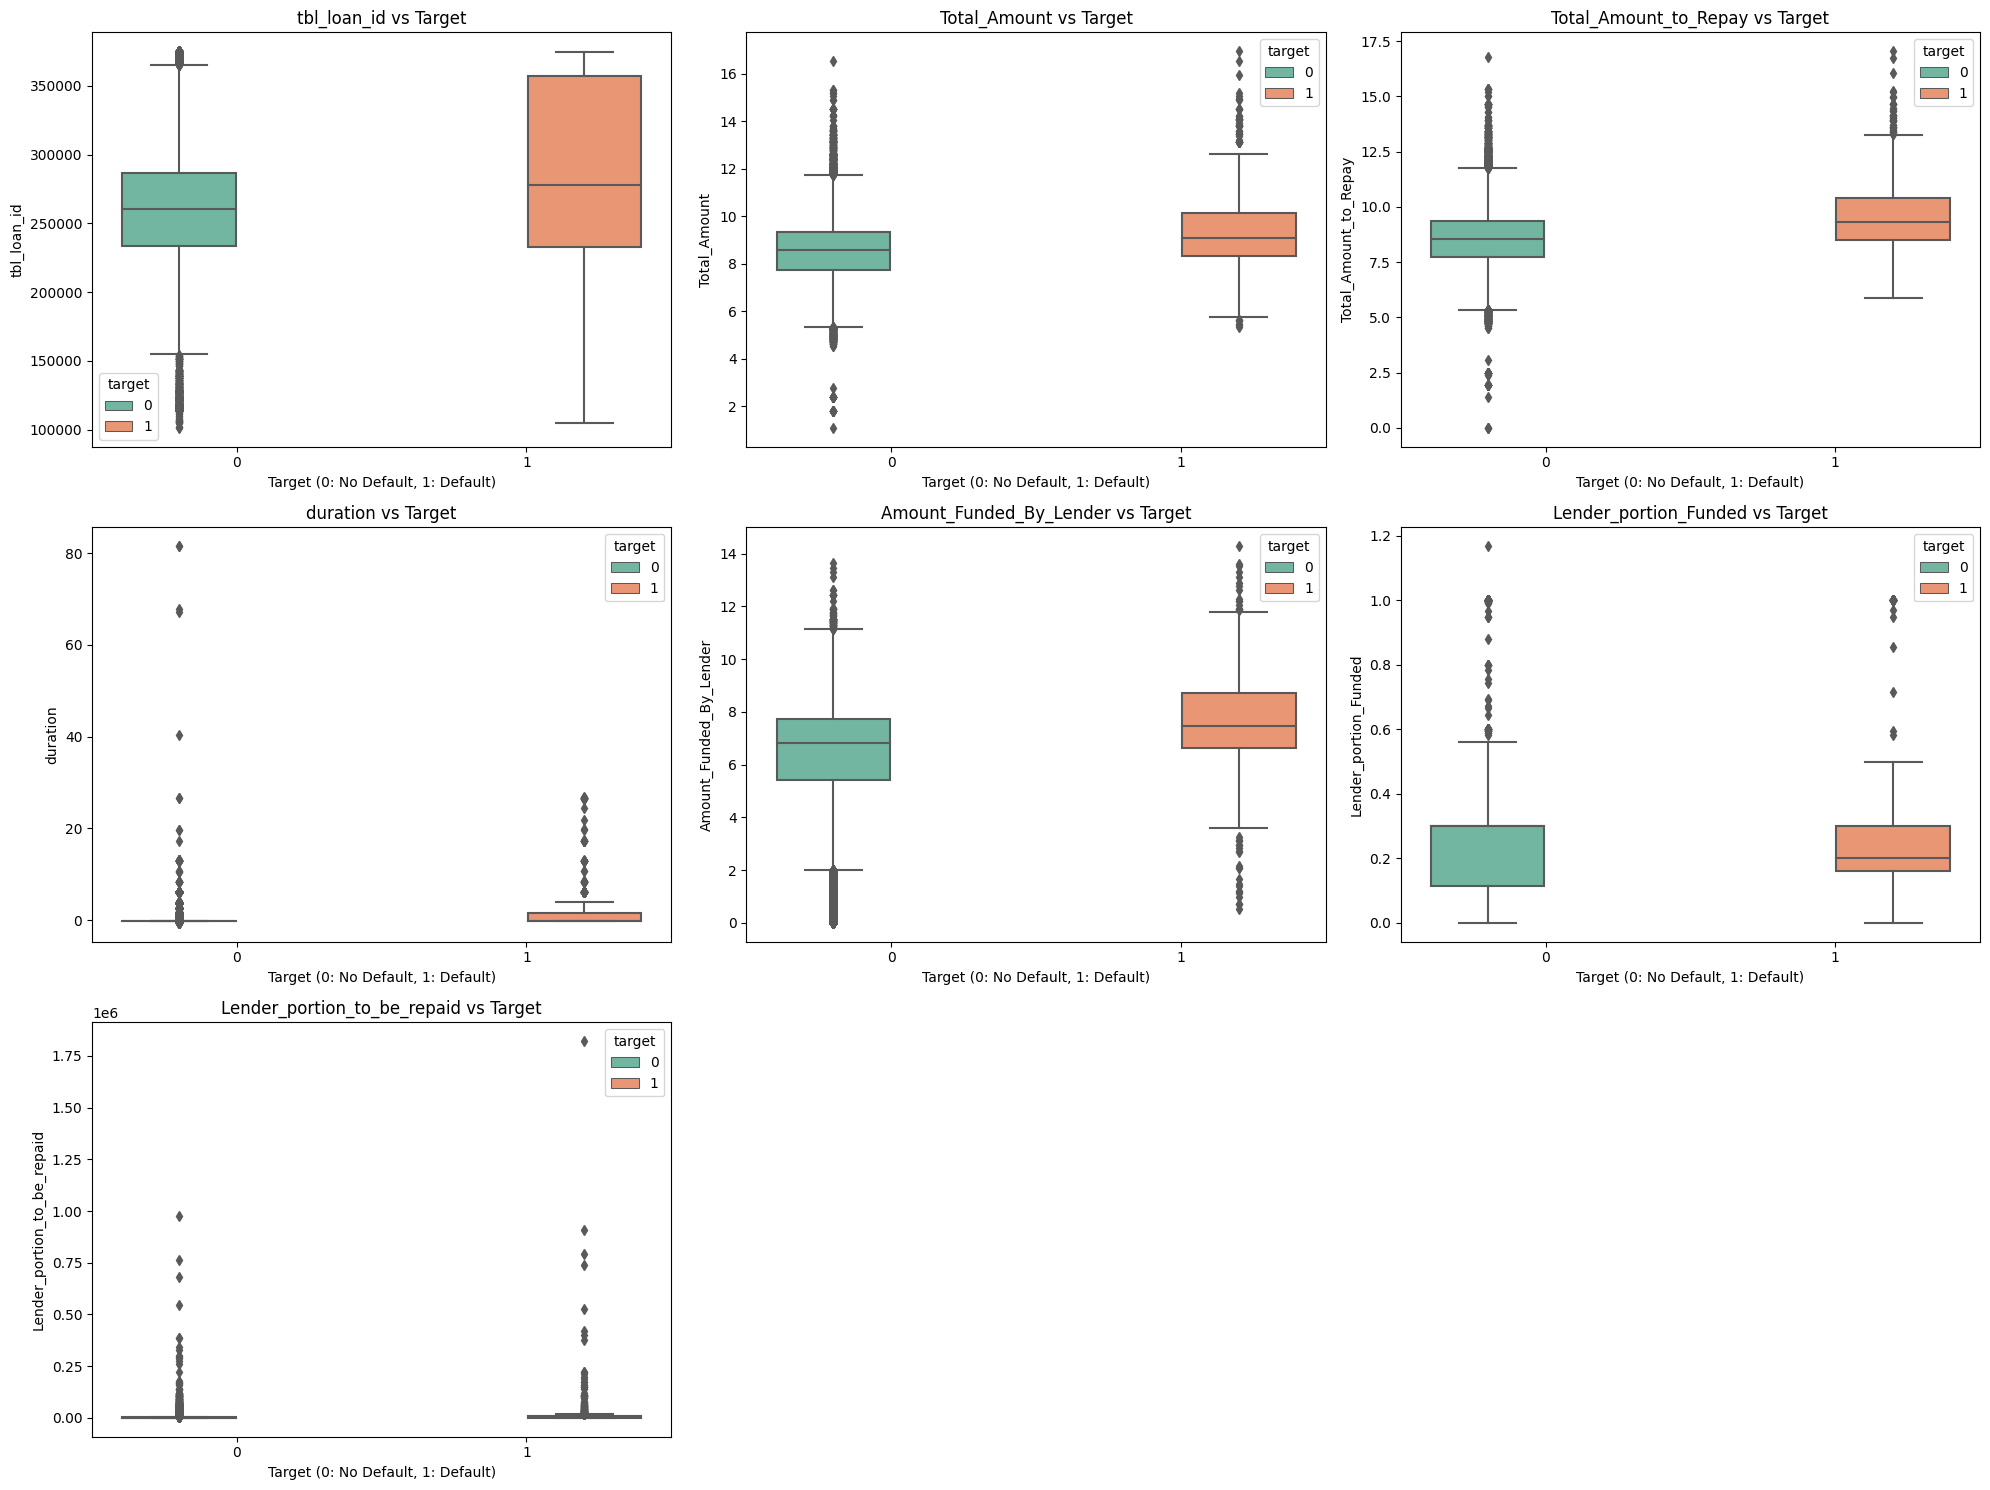

In [11]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_feature, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='target', y=feature, data=train_data, hue='target', palette='Set2')
    plt.title(f'{feature} vs Target')
    plt.xlabel('Target (0: No Default, 1: Default)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [12]:
# List of features with outliers
outlier_features = [
    'Total_Amount', 'Total_Amount_to_Repay', 'Amount_Funded_By_Lender',
    'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'duration'
]

# Cap outliers at the 95th percentile
for feature in outlier_features:
    train_data[feature] = np.clip(train_data[feature], None, np.percentile(train_data[feature], 95))

for feature in outlier_features:
    test_data[feature] = np.clip(test_data[feature], None, np.percentile(test_data[feature], 95))

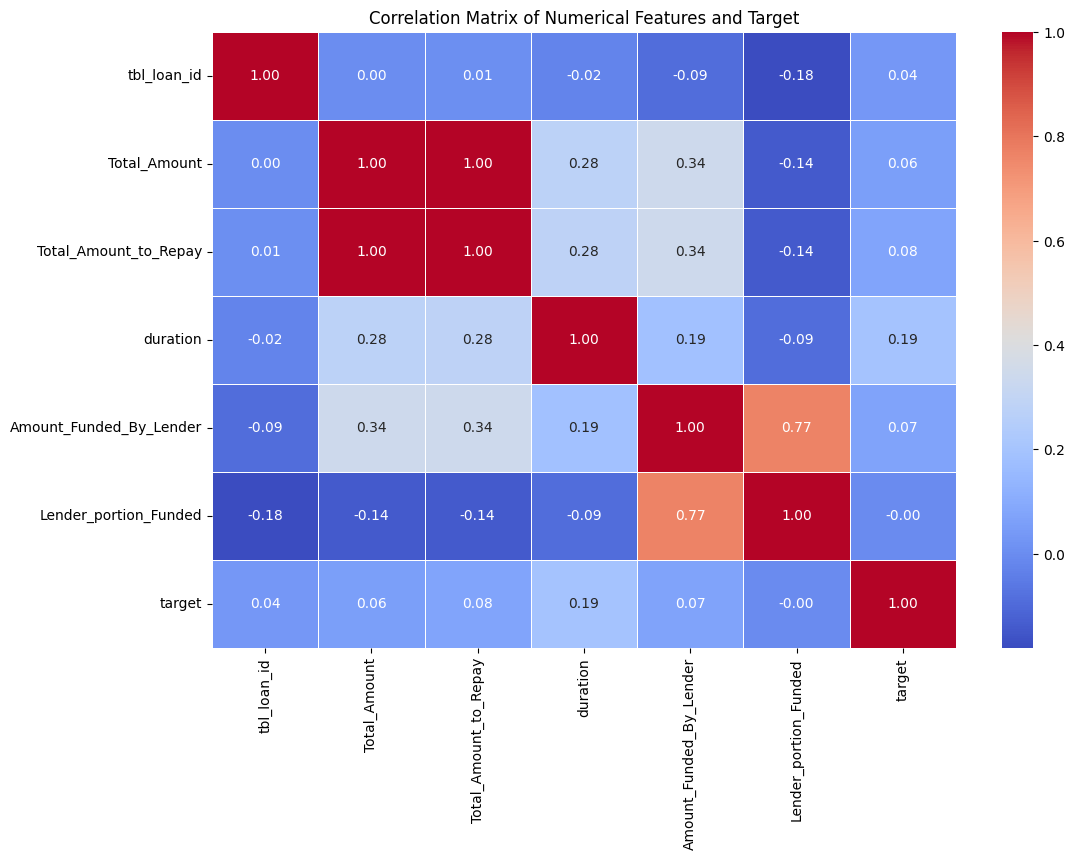

In [13]:
# 5. Correlation Analysis
# Compute correlation matrix
correlation_matrix = train_data[numerical_features + ['target']].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features and Target')
plt.show()

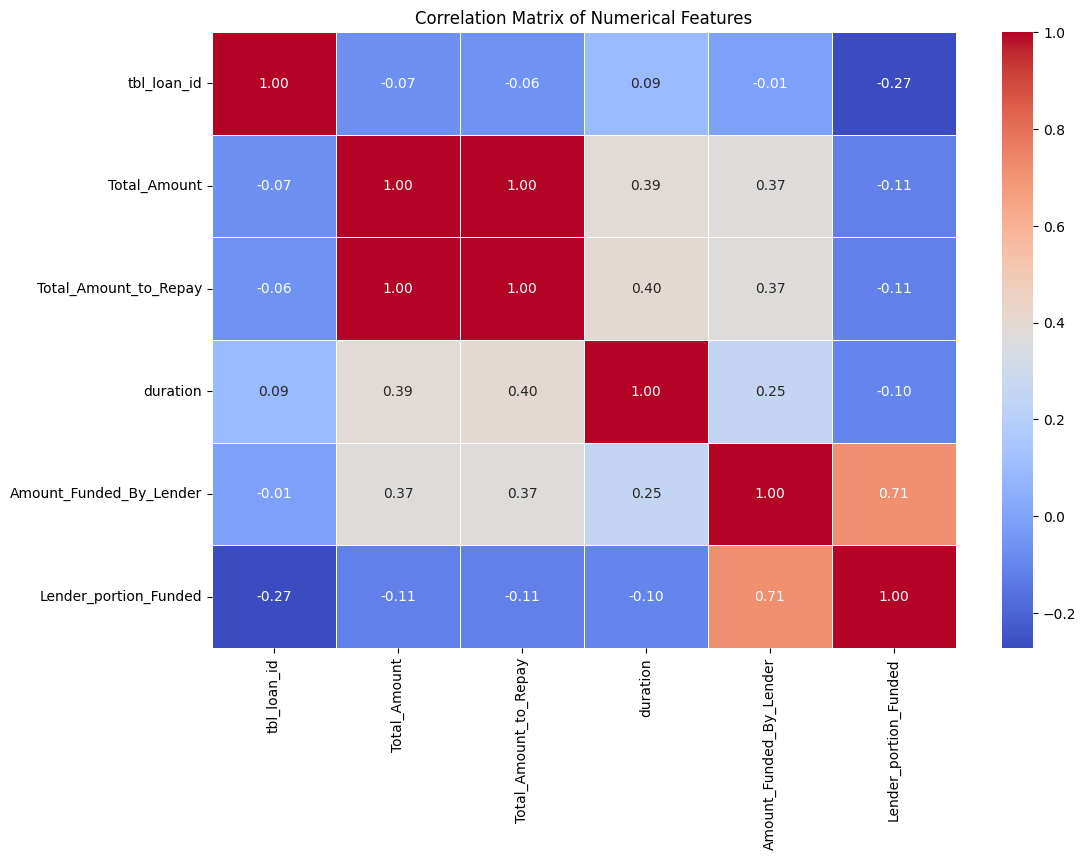

In [14]:
# Compute correlation matrix for only numerical features in the test data
correlation_matrix = test_data[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [15]:
# Concatenate train and test data for unified preprocessing
train_data['is_train'] = 1  # Add a flag to differentiate train data
test_data['is_train'] = 0   # Add a flag to differentiate test data
test_data['target'] = np.nan  # Add a placeholder target column for test data

combined_data = pd.concat([train_data, test_data], axis=0)

# Convert categorical columns to category dtype
combined_data['country_id'] = combined_data['country_id'].astype('category')
combined_data['loan_type'] = combined_data['loan_type'].astype('category')
combined_data['New_versus_Repeat'] = combined_data['New_versus_Repeat'].astype('category')

# Convert date columns to datetime
combined_data['disbursement_date'] = pd.to_datetime(combined_data['disbursement_date'])
combined_data['due_date'] = pd.to_datetime(combined_data['due_date'])

In [16]:
# Feature engineering - Extract date parts
combined_data['disbursement_year'] = combined_data['disbursement_date'].dt.year
combined_data['disbursement_month'] = combined_data['disbursement_date'].dt.month
combined_data['disbursement_dayofweek'] = combined_data['disbursement_date'].dt.dayofweek

combined_data['due_year'] = combined_data['due_date'].dt.year
combined_data['due_month'] = combined_data['due_date'].dt.month
combined_data['due_dayofweek'] = combined_data['due_date'].dt.dayofweek

# Calculate loan duration in days
combined_data['loan_duration_days'] = (combined_data['due_date'] - combined_data['disbursement_date']).dt.days

# One-hot encode categorical columns
combined_data = pd.get_dummies(combined_data, columns=['country_id', 'loan_type', 'New_versus_Repeat'], drop_first=True)

# Separate back into train and test sets
train_data = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train'])
test_data = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'target'])

In [17]:
# Split train data into features (X) and target (y)
X = train_data.drop(columns=['ID','customer_id', 'tbl_loan_id', 'lender_id', 'disbursement_date', 'due_date', 'target'])
y = train_data['target']

# Apply train-test split
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    stratify=y,          # Ensure class balance in splits
    test_size=0.2,       # Use 20% for validation
    shuffle=True,        # Shuffle data to improve generalization
    random_state=42      # Ensure reproducibility
)

# Prepare test features
X_test = test_data.drop(columns=['ID','customer_id', 'tbl_loan_id', 'lender_id', 'disbursement_date', 'due_date'])

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42, sampling_strategy=0.2)  # 20% minority class
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [18]:
# Define the model
model = Sequential([
    Input(shape=(X_train_res.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_valid_scaled, y_valid),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7078 - loss: 0.9307 - val_accuracy: 0.9822 - val_loss: 0.4155 - learning_rate: 3.0000e-04
Epoch 2/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8663 - loss: 0.5751 - val_accuracy: 0.9829 - val_loss: 0.2998 - learning_rate: 3.0000e-04
Epoch 3/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9094 - loss: 0.3970 - val_accuracy: 0.9759 - val_loss: 0.2437 - learning_rate: 3.0000e-04
Epoch 4/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9193 - loss: 0.3156 - val_accuracy: 0.9712 - val_loss: 0.1979 - learning_rate: 3.0000e-04
Epoch 5/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9255 - loss: 0.2623 - val_accuracy: 0.9702 - val_loss: 0.1743 - learning_rate: 3.0000e-04
Epoch 6/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9280 - loss: 0.2311 - val_accuracy: 0.9701 - val_loss: 0.1423 - learning_rate: 3.0000e-04
Epoch 7/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 4s 

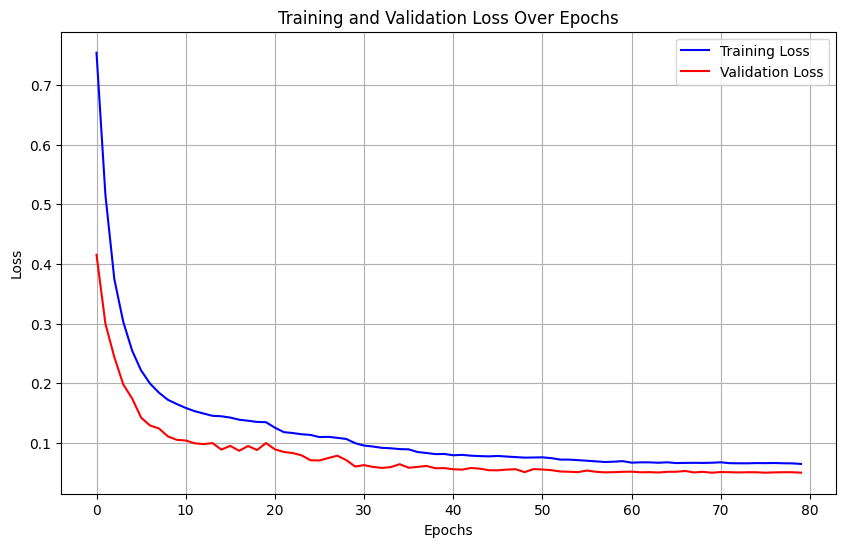

In [19]:
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Evaluate the model
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_valid_preds = (model.predict(X_valid_scaled) > threshold).astype(int)
    f1 = f1_score(y_valid, y_valid_preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")
print("\nClassification Report:")
print(classification_report(y_valid, (model.predict(X_valid_scaled) > best_threshold).astype(int)))

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best Threshold: 0.7, Best F1 Score: 0.7673179396092362

Classification Report:
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     13479
         1.0       0.69      0.86      0.77       252

    accuracy                           0.99     13731
   macro avg       0.85      0.93      0.88     13731
weighted avg       0.99      0.99      0.99     13731



430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

F1 Score: 0.7168
ROC AUC Score: 0.9855


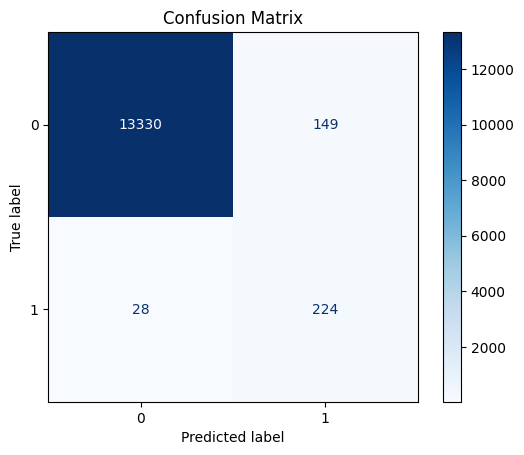

In [21]:
# Predictions
y_pred = (model.predict(X_valid_scaled) > 0.5).astype(int).flatten()
y_pred_proba = model.predict(X_valid_scaled).flatten()

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"\nF1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_pred,
    display_labels=[0, 1],
    cmap=plt.cm.Blues
)

plt.title("Confusion Matrix")
plt.show()

In [22]:
# Make predictions on the test dataset
test_predictions = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
test_predictions_proba = model.predict(X_test_scaled).flatten()

# Save the predictions to a CSV file
test_data['target'] = test_predictions  # Add predictions to the test_data DataFrame
submission = test_data[['ID', 'target']]  # Replace 'customer_id' with your ID column
submission.to_csv('submission.csv', index=False)

print("\nPredictions saved to 'submission.csv'")

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Predictions saved to 'submission.csv'
